In [1]:
import os, sys

PATH_DATA = os.path.dirname(os.path.dirname(os.getcwd()))
PATH_DATA

'/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index'

In [34]:
import pandas as pd
import numpy as np
import shapefile as shp
import osmnx as ox
import contextily as ctx
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D  # for legend handle
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics.pairwise import haversine_distances
from shapely.geometry import Point
from pyproj import Proj, transform
import math
from matplotlib.colors import Normalize

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "../src"))
import functions_support as fsupport

import importlib

importlib.reload(fsupport)

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import hashlib
from datetime import datetime, timedelta

In [35]:
from shapely.ops import cascaded_union, unary_union

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

from shapely.geometry import MultiPolygon, Polygon
from shapely.wkt import loads

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy.spatial import Voronoi, voronoi_plot_2d
import hashlib

In [47]:
def complete_missing_elements(lst):
    # Obtén la lista de todos los números presentes en la lista original
    numbers = [sublst[0] for sublst in lst]

    # Encuentra el valor mínimo y máximo de esos números
    min_number = min(numbers)
    max_number = max(numbers)

    # Crea una nueva lista con todos los números en el rango desde el mínimo hasta el máximo
    complete_lst = [[num, None] for num in range(min_number, max_number + 1)]

    # Itera sobre la lista original y agrega elementos None en la posición correspondiente
    for sublst in lst:
        number = sublst[0]
        value = sublst[1]
        complete_lst[number - min_number][1] = value

    return complete_lst


def hash_point(point):
    decimales = 5
    lat, lon = round(point.x, decimales), round(point.y, decimales)
    # lat, lon = point.x, point.y
    coordinate_str = f"{lat},{lon}"
    # hash_object = hashlib.sha256(coordinate_str.encode())
    # return hash_object.hexdigest()
    return coordinate_str


def area_shape_function(administrative_areas):
    area = administrative_areas.copy()
    area = area.to_crs(epsg=4326)
    area = area.unary_union
    area = gpd.GeoDataFrame(geometry=[area])
    area_shape = area.iloc[0].geometry
    return area_shape


def gdf_voronoi_function(data, area_shape):
    gdf = data.copy()
    gdf = gdf.to_crs(epsg=4326)
    print("Total de elementos:", len(gdf))
    gdf['hash'] = gdf['geometry'].apply(hash_point)
    gdf.drop_duplicates(subset='hash', keep='first', inplace=True)
    del gdf['hash']
    print("Eliminando puntos duplicados:", len(gdf))
    gdf = gdf[gdf.within(area_shape)].reset_index(drop=True)
    print("Eliminando areas fuera del poligono:", len(gdf))
    
    coords = points_to_coords(gdf.geometry)
    unique_coords, unique_indices = np.unique(coords, axis=0, return_index=True)
    region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)
    
    elements = []
    for i in range(0,len(region_polys)):
        pol = region_polys[i]
        lista = region_pts[i]
        for ind in lista:
            elements.append([ind, pol])

    elements = sorted(elements, key=lambda x: x[0])
    elements = complete_missing_elements(elements)
    elements = [e[1] for e in elements]

    gdf['geometry'] = elements
    gdf = gdf[~(gdf["geometry"].isna())].reset_index(drop=True)
    
    print("Poligonos procesados:", len(gdf))
    return gdf[['hospital','geometry']]


# def gdf_voronoi_function2(data, area_shape):
#     gdf = data.copy()
#     gdf = gdf.to_crs(epsg=4326)
    
#     coordinates = np.array(gdf['geometry'].apply(lambda geom: (geom.centroid.x, geom.centroid.y)).to_list())
#     vor = Voronoi(coordinates)
#     # coordinates

#     gdf['region'] = None
#     for i, region_index in enumerate(vor.point_region):
#         vertex_indices = vor.regions[region_index]
#         if -1 not in vertex_indices and len(vertex_indices) >= 3:
#             vertices = vor.vertices[vertex_indices]
#             polygon = gpd.GeoSeries([Polygon(vertices)]).iloc[0]
#             gdf.at[i, 'region'] = polygon
#     gdf = gdf[~(gdf['region'].isna())].reset_index(drop=True)
#     gdf['geometry'] = gdf['region'] 
#     gdf = gdf[['hospital','geometry']]
#     gdf = gdf[gdf['geometry'].intersects(area_shape)]
#     gdf = gdf.reset_index(drop=True)
#     return gdf


def voronoi_join_nearest_points(
    population_shock_df, country_hospitals_voronoi,
):
    country_hospitals_voronoi["region"] = country_hospitals_voronoi.geometry
    data_temp = gpd.sjoin(population_shock_df, country_hospitals_voronoi, how='left', predicate="within")
    
    # Parte 1
    data_temp1 = data_temp[~(data_temp["region"].isna())].reset_index(drop=True)
    del data_temp1["index_right"]
    
    # Parte 2
    data_temp2 = data_temp[(data_temp["region"].isna())].reset_index(drop=True) 
    data_temp2 = data_temp2[population_shock_df.columns]
    data_temp2 = gpd.sjoin_nearest(data_temp2, country_hospitals_voronoi, how='left', distance_col="distances")
    del data_temp2["index_right"]
    del data_temp2["distances"]

    data_temp = pd.concat([data_temp1, data_temp2])
    data_temp['hospital'] = data_temp['hospital'].astype(int)
    # data_temp['hospital'] = data_temp['hospital'].astype(str)

    return data_temp


def voronoi_antennae_join_nearest_points(
    population_shock_df, country_hospitals_voronoi,
):
    country_hospitals_voronoi["region"] = country_hospitals_voronoi.geometry
    data_temp = gpd.sjoin(population_shock_df, country_hospitals_voronoi, how='left', predicate="within")
    
    # Parte 1
    data_temp1 = data_temp[~(data_temp["region"].isna())].reset_index(drop=True)
    del data_temp1["index_right"]
    
    # Parte 2
    data_temp2 = data_temp[(data_temp["region"].isna())].reset_index(drop=True) 
    data_temp2 = data_temp2[population_shock_df.columns]
    data_temp2 = gpd.sjoin_nearest(data_temp2, country_hospitals_voronoi, how='left', distance_col="distances")
    del data_temp2["index_right"]
    del data_temp2["distances"]

    data_temp = pd.concat([data_temp1, data_temp2])
    data_temp['id'] = data_temp['id'].astype(int)
    # data_temp['hospital'] = data_temp['hospital'].astype(str)

    return data_temp


In [3]:
def generar_fechas(num_dias=2880):
    fecha_base = datetime(2010, 1, 1)
    fechas = [fecha_base + timedelta(days=i) for i in range(num_dias)]
    return fechas

# Define a hashing function
def hash_geometry(geometry):
    # Convert the geometry to a string representation
    geometry_str = str(geometry)
    # Hash the string representation using SHA-256
    hashed_geometry = hashlib.sha256(geometry_str.encode()).hexdigest()
    return hashed_geometry

def group_hospitals_by_hosp_month_year(dataframe):
        fechas_generadas = generar_fechas(dataframe['day'].max())
        dataframe['date'] = dataframe['day'].apply(lambda x: fechas_generadas[x-1])
        dataframe['year'] = dataframe['date'].dt.year
        # dataframe['month'] = dataframe['date'].dt.month
        
        grouped_data = dataframe.groupby(['Hospital', 
                                        'year', 
                                        #   'month',
                                        ]
                                        ).agg(
                                            temperature=("temperature", "mean"),
                                            # temperature_mean=("temperature", "mean"),
                                            # temperature_std=("temperature", "std"),
                                            # temperature_max=("temperature", "max"),
                                            # temperature_min=("temperature", "min"),
                                        ).reset_index()
        return grouped_data

## Global variables


In [5]:
COUNTRY_NAME = "peru"
RESULT_DIR = "results_INEI"

In [6]:
directory = PATH_DATA + "/data/" + COUNTRY_NAME + "/" + RESULT_DIR
if not os.path.exists(directory):
    os.makedirs(directory)
    
directory_temperature = f"{directory}/Temperature"
if not os.path.exists(directory_temperature):
    os.makedirs(directory_temperature)
    
directory_prioritization = f"{directory}/Prioritization"
if not os.path.exists(directory_prioritization):
    os.makedirs(directory_prioritization)

## Administrative areas


In [7]:
path = (
    PATH_DATA + "/data/" + COUNTRY_NAME + "/preprocessed_sources/administrative_region"
)
files = os.listdir(path)

administrative_areas_dict = dict()

for i in files:
    name = fsupport.capitalize_string(i[:-8])
    # adminitration = fsupport.capitalize_string(i[-9:-8])
    # # key_tag = f'{name} {fsupport.category_dict[adminitration]}'
    # key_tag = f'{name}{adminitration}'
    administrative_areas_dict[name] = gpd.read_file(path + "/" + i)

administrative_areas_dict.keys()

dict_keys(['Administration 2', 'Administration 3', 'Administration 1'])

## Temperatures


In [7]:
def kelvin_to_celsius(kelvin):
    celsius = kelvin - 273.15
    return celsius

In [8]:
path = f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/temperatura/peru_salida_shape.shp"
path = f"{PATH_DATA}/data/{COUNTRY_NAME}/temperatura_mensual_peru_2010_2019/temperatura_mensual_peru_2010_2019.shp"

temp_shape = gpd.read_file(path)

temp_shape = temp_shape.rename(
    columns={"value": "temperature",
             "band": "day"}
)                              

temp_shape['temperature'] = temp_shape['temperature'].apply(lambda x: kelvin_to_celsius(x))

print(len(temp_shape))
temp_shape.head()

11082240


day  temperature                                           geometry
0    1    25.313379  POLYGON ((-81.53500 0.03500, -81.28500 0.03500...
1    1    25.383691  POLYGON ((-81.28500 0.03500, -81.03500 0.03500...
2    1    25.396875  POLYGON ((-81.03500 0.03500, -80.78500 0.03500...
3    1    25.608301  POLYGON ((-80.78500 0.03500, -80.53500 0.03500...
4    1    25.714258  POLYGON ((-80.53500 0.03500, -80.28500 0.03500...

MovieWriter ffmpeg unavailable; using Pillow instead.


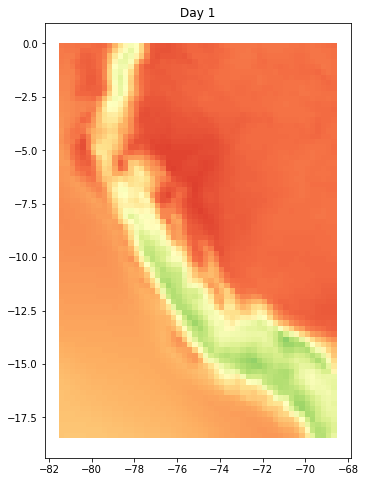

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))

columna_color = 'temperature'
time_unit = sorted(set(temp_shape['day'])) #[:24*1] #[:24*33]

temperaturas_min = temp_shape[columna_color].min()
temperaturas_max = temp_shape[columna_color].max()

def animate(i):
    sub_data = temp_shape[temp_shape['day'] == time_unit[i]]
    
    ax.clear()
    # ax.set_xlim([-82.0, -66.0]) # Límites en la coordenada X
    # ax.set_ylim([-4.9, 14.0]) # Límites en la coordenada Y
    sub_data.plot(column=columna_color, ax=ax, legend=False, cmap='RdYlGn_r', vmin=temperaturas_min, vmax=temperaturas_max)
    ax.set_title('Day {}'.format(time_unit[i]))
    return ax

ani = FuncAnimation(fig, animate, frames=len(time_unit), repeat=True)

ani.save(f'{directory_temperature}/video_day_temperature.gif', writer='ffmpeg', fps=24*3, dpi=100)

In [ ]:
temp_shape['grid'] = temp_shape['geometry'] 
temp_shape['geometry'] = temp_shape['geometry'].centroid
temp_shape['hashed_geometry'] = temp_shape['grid'].apply(hash_geometry)
temp_shape.head()

day  temperature                    geometry   
0    1    25.313379  POINT (-81.41000 -0.09000)  \
1    1    25.383691  POINT (-81.16000 -0.09000)   
2    1    25.396875  POINT (-80.91000 -0.09000)   
3    1    25.608301  POINT (-80.66000 -0.09000)   
4    1    25.714258  POINT (-80.41000 -0.09000)   

                                                grid   
0  POLYGON ((-81.53500 0.03500, -81.28500 0.03500...  \
1  POLYGON ((-81.28500 0.03500, -81.03500 0.03500...   
2  POLYGON ((-81.03500 0.03500, -80.78500 0.03500...   
3  POLYGON ((-80.78500 0.03500, -80.53500 0.03500...   
4  POLYGON ((-80.53500 0.03500, -80.28500 0.03500...   

                                     hashed_geometry  
0  01b3d2b8d72fcf510feff95b1f63c48ff65e39bc330494...  
1  04076ad5b5779d21aa2d24e32eb5c478f20fe5c2db86e9...  
2  9aa8efb346eb746019e4894db69b9666c646f56fecd6e8...  
3  460d33fa1d83b8f54ad81121b564254b0cd2776f1c35b5...  
4  538b4f4fa43cd5448b607695c6b3fa530deb2710cbd3d8...

In [ ]:
df_pivot = (
        temp_shape.groupby(
            [
                "hashed_geometry",
            ]
        )
        .agg(
            geometry=("geometry", "first"),
            grid=("grid", "first"),
        )
        .reset_index()
    )
df_pivot = gpd.GeoDataFrame(df_pivot, geometry=df_pivot['geometry'])
print(len(df_pivot))
df_pivot.head(3)

3848


/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


hashed_geometry   
0  00128e20db35cf509cc0fa767c58963a5b1aa90709dd02...  \
1  002803c0a57a82224e9fbac021559b11eea2785755c598...   
2  00282f9da06e722ed4fa790e1097e3f9f40565357eccf8...   

                      geometry   
0  POINT (-77.16000 -15.09000)  \
1   POINT (-76.66000 -0.59000)   
2  POINT (-78.91000 -14.34000)   

                                                grid  
0  POLYGON ((-77.28500 -14.96500, -77.03500 -14.9...  
1  POLYGON ((-76.78500 -0.46500, -76.53500 -0.465...  
2  POLYGON ((-79.03500 -14.21500, -78.78500 -14.2...

## Shock

We will only work with the list of hazards that are enabled for our study.


In [43]:
shock_dict = {
    # "floods": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/1_floods/Áreas_de_exposición.shp",
    # "mass movements": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/2_mass movements/Áreas_de_exposición.shp",
    # "droughts": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/4_Sequias/sequias_severas.shp",
    # "landslide": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/3_huaycos/view_av_activ_qdra.shp",
    "frost": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/5_6_Heladas_friaje/Heladas.shp",
    "extreme cold": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/5_6_Heladas_friaje/Friajes.shp",
    "snow": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/7_Snow/snow_peru.shp",
}

In [44]:
SHOCK_NAME = 'frost'

path_shock_file = shock_dict[SHOCK_NAME]
shock_shape = fsupport.shock_shape(path=path_shock_file, shock_name=SHOCK_NAME)
shock_shape = shock_shape.unary_union

shock_shape

In [45]:
shock_dict.keys()

dict_keys(['frost', 'extreme cold', 'snow'])

### Temperatures per shock

In [46]:
time_series = pd.DataFrame()

for SHOCK_NAME in shock_dict.keys():
# for SHOCK_NAME in list(shock_dict.keys())[:1]:
    print("Shock: " + SHOCK_NAME)

    path_resp_shock = (
        PATH_DATA + "/data/" + COUNTRY_NAME + "/" + RESULT_DIR + "/" + SHOCK_NAME
    )
    if not os.path.exists(path_resp_shock):
        os.makedirs(path_resp_shock)

    # Reading shape
    path_shock_file = shock_dict[SHOCK_NAME]
    shock_shape = fsupport.shock_shape(path=path_shock_file, shock_name=SHOCK_NAME)
    shock_shape = shock_shape.unary_union
    
    # Intersection
    points_within_polygon = df_pivot[df_pivot.geometry.within(shock_shape)]['hashed_geometry'].values
    filtered_gdf = temp_shape[temp_shape.hashed_geometry.isin(points_within_polygon)]
    data_temp = (
        filtered_gdf.groupby(
            [
                "day",
            ]
        )
        .agg(
            temperature_mean=("temperature", "mean"),
            temperature_std=("temperature", "std"),
            temperature_max=("temperature", "max"),
            temperature_min=("temperature", "min"),
        )
        .reset_index()
    )
    data_temp['shock'] = SHOCK_NAME
    # time_series.to_csv( f"temp_{SHOCK_NAME}.csv", index=False)
    
    time_series = pd.concat([time_series, data_temp])
    print()


time_series.to_csv(f"{directory_temperature}/temperature_day_table.csv", index=False)

Shock: frost

Shock: extreme cold

Shock: snow



## Time Serie

In [47]:
time_series = pd.read_csv(f"{directory_temperature}/temperature_day_table.csv")
time_series.head()

day  temperature_mean  temperature_std  temperature_max  temperature_min   
0    1         10.871307         4.917457        26.137598         2.176660  \
1    2         10.546254         5.013596        26.070947         1.519678   
2    3          9.861679         4.937668        24.698145         0.698633   
3    4          9.530756         5.009326        24.233789         0.217188   
4    5          9.392291         5.040878        23.838281         0.122461   

   shock  
0  frost  
1  frost  
2  frost  
3  frost  
4  frost

In [48]:
# import plotly.graph_objects as go
# import kaleido


In [49]:
# # Obtener la lista de colores únicos en el gráfico
# unique_colors = time_series['shock'].unique()

# # Asignar un tipo de línea diferente para cada color
# for i, color in enumerate(unique_colors):
#     fig.update_traces(selector=dict(name=color), line=dict(dash='dash' if i % 2 == 0 else 'dot'))


fig = px.line(time_series, x="day", y="temperature_mean", color='shock')
fig.update_layout(
    width=1200,  
    height=450  
)
fig.write_image(f"{directory_temperature}/temperatura_year_mean_figure.png",  engine='kaleido')
fig.show()

In [50]:
# fig = px.line(time_series, x="day", y="temperature_mean", color='shock')
# fig.show()

In [51]:
# fig = px.bar(time_series, x='day', y='temperature_mean', color='shock', height=400)
# fig.show()

In [52]:
fechas_generadas = generar_fechas(time_series['day'].max())

In [53]:
time_series['date'] = time_series['day'].apply(lambda x: fechas_generadas[x-1])


def group_by_month_year(dataframe):
    dataframe['year'] = dataframe['date'].dt.year
    dataframe['month'] = dataframe['date'].dt.month
    
    grouped_data = dataframe.groupby(['shock', 'year', 'month']).agg(
                    temperature_mean=("temperature_mean", "mean"),
                    temperature_std=("temperature_std", "max"),
                    temperature_max=("temperature_max", "max"),
                    temperature_min=("temperature_min", "min"),
                    ).reset_index()
    return grouped_data

df_grouped = group_by_month_year(time_series)
df_grouped['date'] = pd.to_datetime(df_grouped[['year', 'month']].assign(day=1))
df_grouped.to_csv(f"{directory_temperature}/temperatura_montly_table.csv", index=False)

In [54]:
fig = px.line(df_grouped, x=["date"], y="temperature_mean", color='shock')
# Obtener la lista de colores únicos en el gráfico
unique_colors = df_grouped['shock'].unique()

# Asignar un tipo de línea diferente para cada color
for i, color in enumerate(unique_colors):
    fig.update_traces(selector=dict(name=color), line=dict(dash='dash' if i % 2 == 0 else 'dot'))
fig.update_layout(
    width=1200,  
    height=450  
)
fig.write_image(f"{directory_temperature}/temperatura_montly_mean_figure.png",  engine='kaleido')
fig.show()

In [55]:
fig = px.line(df_grouped, x=["date"], y="temperature_min", color='shock')
# Obtener la lista de colores únicos en el gráfico
unique_colors = df_grouped['shock'].unique()

# Asignar un tipo de línea diferente para cada color
for i, color in enumerate(unique_colors):
    fig.update_traces(selector=dict(name=color), line=dict(dash='dash' if i % 2 == 0 else 'dot'))
    
fig.update_layout(
    width=1200,  
    height=450  
)
fig.write_image(f"{directory_temperature}/temperatura_montly_min_figure.png",  engine='kaleido')
fig.show()

## Hospitals and temperatures

In [34]:
import importlib
# from healthcare_facilities_priority import *
import healthcare_facilities_priority
importlib.reload(healthcare_facilities_priority)

from shapely import wkt

df_pivot_temp = df_pivot.copy()
df_pivot_temp['centroid'] = df_pivot_temp['geometry']
df_pivot_temp['geometry'] = df_pivot_temp['grid']

In [9]:
shock_dict = {
    "floods": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/1_floods/Áreas_de_exposición.shp",
    "mass movements": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/2_mass movements/Áreas_de_exposición.shp",
    "droughts": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/4_Sequias/sequias_severas.shp",
    "landslide": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/3_huaycos/view_av_activ_qdra.shp",
    "frost": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/5_6_Heladas_friaje/Heladas.shp",
    "extreme cold": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/5_6_Heladas_friaje/Friajes.shp",
    "snow": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/7_Snow/snow_peru.shp",
}
shock_dict

{'floods': '/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/original_sources/shocks_shapes/1_floods/Áreas_de_exposición.shp',
 'mass movements': '/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/original_sources/shocks_shapes/2_mass movements/Áreas_de_exposición.shp',
 'droughts': '/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/original_sources/shocks_shapes/4_Sequias/sequias_severas.shp',
 'landslide': '/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/original_sources/shocks_shapes/3_huaycos/view_av_activ_qdra.shp',
 'frost': '/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/original_sources/shocks_shapes/5_6_Heladas_friaje/Heladas.shp',
 'extreme cold': '/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/original_sources/shocks_shapes/5_6_Heladas_friaje/Friajes.shp',
 'snow': '/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_i

In [10]:
# #Read exposed population
# df_exposed_population = pd.read_csv('peru_exposed_population_floods_adm3_table.csv')
# #Read exposed healthcare infrastructure
# df_health_infrastructure = pd.read_csv('peru_health_infrastructure_floods_table.csv')
# #Read danger (flood, landslides, etc) variables
# df_danger_variables =  pd.read_csv('peru_floods_variables_table.csv')

factor_variables = ['Administration 3 Code','Per Indigenous Pop', 'Per Pobrezanbi', 
             'Per Desnutricion', 'ValorConcentracióndeEESSdel', 'ValorEESSconmayorcapacidadr', 
             'MEDICOX10000HABITANTENORMAL','Per Ess 100hab', 'PHC Dist Km', 'Hospital Dist Km']

variables_for_prioritization = ['Exposed Pop','Per Indigenous Pop','Per Pobrezanbi', 'Per Desnutricion', 'ValorConcentracióndeEESSdel']

In [11]:
time_series = pd.DataFrame()

for SHOCK_NAME in shock_dict.keys():
# for SHOCK_NAME in list(shock_dict.keys())[:1]:
    print("Shock: " + SHOCK_NAME)
    
    # Read exposed population
    path_resp_shock = f"{directory}/{SHOCK_NAME}/peru_exposed_population_{SHOCK_NAME}_adm3_table.csv"
    df_exposed_population = pd.read_csv(path_resp_shock, dtype={
                                                                "Administration 3 Code": str,
                                                            },)
    
    # Read danger (flood, landslides, etc) variables
    path_resp_shock = f"{directory}/{SHOCK_NAME}/peru_health_infrastructure_{SHOCK_NAME}_table.csv"
    df_health_infrastructure = pd.read_csv(path_resp_shock, dtype={
                                                                "Administration 3 Code": str,
                                                            },)
    df_health_infrastructure =  pd.merge(
                                    df_health_infrastructure,
                                    administrative_areas_dict['Administration 3'][['administration_3_code','administration_1','administration_2','administration_3']],
                                    how="left", 
                                    left_on=['Administration 3 Code'], 
                                    right_on=['administration_3_code']
                                )

    df_health_infrastructure = gpd.GeoDataFrame(df_health_infrastructure)
    df_health_infrastructure['geometry'] = df_health_infrastructure['geometry'].apply(wkt.loads)
    
    # Read danger (flood, landslides, etc) variables
    path_resp_shock = f"{directory}/{SHOCK_NAME}/peru_{SHOCK_NAME}_variables_table.csv"
    df_danger_variables = pd.read_csv(path_resp_shock)
    
    df_health_infrastructure = healthcare_facilities_priority.healthcare_prioritization(df_exposed_population,df_health_infrastructure,df_danger_variables,factor_variables)

    top = 10
    healthcare_facilities_priority.prioritization_national_level(df_health_infrastructure,
                                  variables_for_prioritization,
                                  top,
                                  "Peru", 
                                  SHOCK_NAME, 
                                  f"{directory_prioritization}")
    
    pxd_phc, pxd_hosp = healthcare_facilities_priority.prioritization_by_department_level(df_health_infrastructure,
                                                                      variables_for_prioritization,
                                                                      "Peru",
                                                                      SHOCK_NAME,
                                                                      f"{directory_prioritization}")
    
    # Temperatures
    
    if SHOCK_NAME in ["frost", "extreme cold", "snow"]:
        hospital_temp = df_health_infrastructure[['Hospital', 'geometry']].copy()
        hospital_temp = gpd.sjoin(hospital_temp,
                                df_pivot_temp[['hashed_geometry','geometry']], 
                                how='inner', 
                                predicate='intersects')

        hospital_temp = pd.merge(
                            hospital_temp[['Hospital', 'hashed_geometry']],
                            temp_shape[['day','temperature', 'hashed_geometry']],
                            how="left", 
                            left_on=['hashed_geometry'], 
                            right_on=['hashed_geometry']
                        )

        hospital_temp = group_hospitals_by_hosp_month_year(hospital_temp)



        hospital_temp = hospital_temp.pivot(index=['Hospital'], 
                                            columns=['year']
                                        ).reset_index()
        hospital_temp.columns = hospital_temp.columns.to_flat_index()
        hospital_temp.columns = hospital_temp.columns.map(lambda x: f"{x[0]}_{x[1]}")

        hospital_temp = hospital_temp.rename(
            columns={"Hospital_": "Hospital",}
        )

        hospital_temp = pd.merge(
                            df_health_infrastructure,
                            hospital_temp,
                            how="left", 
                            left_on=['Hospital'], 
                            right_on=['Hospital']
                        )

        path = f"{directory_temperature}/Peru_{SHOCK_NAME}_hospitals_temperature_table.csv"
        hospital_temp.to_csv(path, index=False)
    pass

Shock: floods


NameError: name 'wkt' is not defined

In [43]:
set(df_health_infrastructure[(df_health_infrastructure['Shock Name']==1) &
                             (df_health_infrastructure['Nivel']!=1)]['administration_1'])

{'APURIMAC',
 'CAJAMARCA',
 'CALLAO',
 'ICA',
 'LA LIBERTAD',
 'LAMBAYEQUE',
 'LIMA',
 'PIURA',
 'TACNA',
 'TUMBES'}

In [44]:
df_health_infrastructure[(df_health_infrastructure['Shock Name']==1) &
                             (df_health_infrastructure['Nivel']!=1) &
                             (df_health_infrastructure['administration_1']=='APURIMAC')]

Hospital                                         Name  Nivel   
169      7719  HOSPITAL REGIONAL GUILLERMO DIAZ DE LA VEGA      2  \

                        geometry  Administration 1 Code   
169  POINT (-72.88198 -13.64035)                      3  \

     Administration 2 Code  Administration 3 Code  Shock Name   
169                    301                  30101           1  \

    administration_3_code administration_1  ... administration_3 Exposed Pop   
169                030101         APURIMAC  ...          ABANCAY         NaN  \

     Per Indigenous Pop  Per Pobrezanbi  Per Desnutricion   
169             0.78437           0.158             0.114  \

     ValorConcentracióndeEESSdel  MEDICOX10000HABITANTENORMAL  Per Ess 100hab   
169                         0.07                     3.643994        3.169271  \

      PHC Dist Km  Hospital Dist Km  
169  14506.787429      14509.394512  

[1 rows x 21 columns]

### matriz de exposición de hospital a peligros compuestos

In [12]:
list_hazards = list(shock_dict.keys())
import csv

In [19]:

matix_phc = []
for SHOCK_NAME_RAW in list_hazards:
    
    raw_phc_list = []
    raw_phc_list.append(SHOCK_NAME_RAW)
    path = f"{directory_prioritization}/Peru_PHC_priority_{SHOCK_NAME_RAW}.csv"
    phc_raw = pd.read_csv(path)
    phc_raw = set(phc_raw['Hospital'])
    
    
    for SHOCK_NAME_COL in list_hazards:
        
        path = f"{directory_prioritization}/Peru_PHC_priority_{SHOCK_NAME_COL}.csv"
        phc_col = pd.read_csv(path)
        phc_col = set(phc_col['Hospital'])
        
        intersections = len(phc_raw.intersection(phc_col))
        raw_phc_list.append(intersections)
    
    matix_phc.append(raw_phc_list)
    
csv_file_path = f"{directory_prioritization}/Peru_matrix_PHC.csv"
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + list_hazards)
    for row in matix_phc:
        writer.writerow(row)
        
matix_phc    
    

[['floods', 10, 0, 0, 0, 0, 0, 0],
 ['mass movements', 0, 10, 0, 0, 0, 0, 0],
 ['droughts', 0, 0, 10, 5, 10, 0, 3],
 ['landslide', 0, 0, 5, 10, 5, 0, 7],
 ['frost', 0, 0, 10, 5, 10, 0, 3],
 ['extreme cold', 0, 0, 0, 0, 0, 10, 0],
 ['snow', 0, 0, 3, 7, 3, 0, 10]]

In [20]:
matix_priority = []
for SHOCK_NAME_RAW in list_hazards:
    
    raw_priority_list = []
    raw_priority_list.append(SHOCK_NAME_RAW)
    path = f"{directory_prioritization}/Peru_Hospitals_priority_{SHOCK_NAME_RAW}.csv"

    priority_raw = pd.read_csv(path)
    priority_raw = set(priority_raw['Hospital'])
    
    for SHOCK_NAME_COL in list_hazards:
        
        path = f"{directory_prioritization}/Peru_Hospitals_priority_{SHOCK_NAME_COL}.csv"
        priority_col = pd.read_csv(path)
        priority_col = set(priority_col['Hospital'])
        intersections = len(priority_raw.intersection(priority_col))
        raw_priority_list.append(intersections)
    matix_priority.append(raw_priority_list)
    
csv_file_path = f"{directory_prioritization}/Peru_matrix_priority.csv"
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + list_hazards)
    for row in matix_priority:
        writer.writerow(row)
          
matix_priority 

[['floods', 10, 0, 0, 0, 0, 0, 0],
 ['mass movements', 0, 10, 0, 1, 0, 1, 0],
 ['droughts', 0, 0, 10, 3, 9, 0, 1],
 ['landslide', 0, 1, 3, 10, 2, 4, 1],
 ['frost', 0, 0, 9, 2, 10, 0, 2],
 ['extreme cold', 0, 1, 0, 4, 0, 10, 0],
 ['snow', 0, 0, 1, 1, 2, 0, 10]]

In [21]:

matix_phc = []
for SHOCK_NAME_RAW in list_hazards:
    
    raw_phc_list = []
    raw_phc_list.append(SHOCK_NAME_RAW)
    path = f"{directory}/{SHOCK_NAME_RAW}/peru_health_infrastructure_{SHOCK_NAME_RAW}_table.csv"
    phc_raw = pd.read_csv(path)
    phc_raw = phc_raw[(phc_raw['Nivel']==1) & (phc_raw['Shock Name']==1)]
    phc_raw = set(phc_raw['Hospital'])
    
    
    for SHOCK_NAME_COL in list_hazards:
        path = f"{directory}/{SHOCK_NAME_COL}/peru_health_infrastructure_{SHOCK_NAME_COL}_table.csv"
        phc_col = pd.read_csv(path)
        phc_col = phc_col[(phc_col['Nivel']==1) & (phc_col['Shock Name']==1)]
        phc_col = set(phc_col['Hospital'])
        
        intersections = len(phc_raw.intersection(phc_col))
        raw_phc_list.append(intersections)
    
    matix_phc.append(raw_phc_list)
    
csv_file_path = f"{directory_prioritization}/Peru_matrix_PHC.csv"
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + list_hazards)
    for row in matix_phc:
        writer.writerow(row)
        
matix_phc    
    

[['floods', 271, 12, 25, 48, 80, 11, 2],
 ['mass movements', 12, 224, 56, 40, 112, 16, 6],
 ['droughts', 25, 56, 4068, 1079, 3833, 125, 602],
 ['landslide', 48, 40, 1079, 2042, 1597, 408, 310],
 ['frost', 80, 112, 3833, 1597, 5905, 0, 727],
 ['extreme cold', 11, 16, 125, 408, 0, 2051, 11],
 ['snow', 2, 6, 602, 310, 727, 11, 739]]

In [22]:
matix_priority = []
for SHOCK_NAME_RAW in list_hazards:
    
    raw_priority_list = []
    raw_priority_list.append(SHOCK_NAME_RAW)
    path = f"{directory}/{SHOCK_NAME_RAW}/peru_health_infrastructure_{SHOCK_NAME_RAW}_table.csv"
    priority_raw = pd.read_csv(path)
    priority_raw = priority_raw[(priority_raw['Nivel']!=1) & (priority_raw['Shock Name']==1)]
    priority_raw = set(priority_raw['Hospital'])
    
    for SHOCK_NAME_COL in list_hazards:
        path = f"{directory}/{SHOCK_NAME_COL}/peru_health_infrastructure_{SHOCK_NAME_COL}_table.csv"
        priority_col = pd.read_csv(path)
        priority_col = priority_col[(priority_col['Nivel']!=1) & (priority_col['Shock Name']==1)]
        priority_col = set(priority_col['Hospital'])
        intersections = len(priority_raw.intersection(priority_col))
        raw_priority_list.append(intersections)
    matix_priority.append(raw_priority_list)
    
csv_file_path = f"{directory_prioritization}/Peru_matrix_priority.csv"
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + list_hazards)
    for row in matix_priority:
        writer.writerow(row)
          
matix_priority 

[['floods', 32, 0, 0, 3, 2, 0, 0],
 ['mass movements', 0, 18, 1, 1, 5, 1, 0],
 ['droughts', 0, 1, 75, 14, 68, 1, 10],
 ['landslide', 3, 1, 14, 66, 56, 8, 3],
 ['frost', 2, 5, 68, 56, 168, 0, 14],
 ['extreme cold', 0, 1, 1, 8, 0, 50, 0],
 ['snow', 0, 0, 10, 3, 14, 0, 14]]

## Voronoi

In [37]:
path = f"{PATH_DATA}/data/peru/preprocessed_sources/administrative_region"
files = os.listdir(path)

administrative_areas_dict = dict()
for i in files:
    name = fsupport.capitalize_string(i[:-8])
    administrative_areas_dict[name] = gpd.read_file(path + "/" + i)

administrative_areas = administrative_areas_dict[max(administrative_areas_dict.keys())]

filtered_columns = [
    col
    for col in administrative_areas.columns
    if col.endswith("code") or col == "geometry"
]
administrative_areas = administrative_areas[filtered_columns]
administrative_areas = administrative_areas.reindex(
    sorted(administrative_areas.columns), axis=1
)
administrative_areas = administrative_areas.to_crs("EPSG:4326")
administrative_areas.head()

administration_1_code administration_2_code administration_3_code   
0                    10                  1009                100902  \
1                    10                  1009                100904   
2                    25                  2503                250305   
3                    25                  2503                250302   
4                    25                  2503                250304   

                                            geometry  
0  POLYGON ((-75.31797 -9.29529, -75.31710 -9.297...  
1  POLYGON ((-75.20831 -9.10175, -75.20805 -9.101...  
2  POLYGON ((-74.95635 -8.79148, -74.95612 -8.792...  
3  POLYGON ((-75.10843 -8.79990, -75.11753 -8.812...  
4  POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...

In [15]:


catchment_area = f"{directory}/catchment_area"
if not os.path.exists(catchment_area):
    os.makedirs(catchment_area)

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
# Areas
area_shape = area_shape_function(administrative_areas)

# Hospitals
path = f"{PATH_DATA}/data/peru/preprocessed_sources/hospitals.csv"
df_hospitals = pd.read_csv(path)
df_hospitals = fsupport.hosp_join_points(df_hospitals, administrative_areas)
df_hospitals = df_hospitals.dropna(subset=['geometry'])

# Others 
print("PROCESSING HOSPITALS")
country_hospitals = df_hospitals[df_hospitals['nivel']!=1].reset_index(drop=True)
country_hospitals_voronoi = gdf_voronoi_function(country_hospitals, area_shape)

# Population for each region
for SHOCK_NAME_RAW in list_hazards + ['total']:
    print("  ",SHOCK_NAME_RAW)
    if 'total' == SHOCK_NAME_RAW:
        # population_shock_df = gpd.GeoDataFrame(population_shock_df, crs="EPSG:4326")
        path = PATH_DATA + "/data/peru/preprocessed_sources/population.geojson"
        population_shock_df = gpd.read_file(path)
        population_shock_df = fsupport.extract_centroid_if_exist(population_shock_df)
        population_shock_df = population_shock_df[['population','geometry']]
        population_shock_df = population_shock_df.rename(columns={"population": 'Population'})
        population_shock_df['population_id'] = population_shock_df.index
        data_temp = voronoi_join_nearest_points(population_shock_df, country_hospitals_voronoi)
        data_temp = data_temp.groupby(['hospital']).agg(
                                                Population=("Population", "sum")
                                            ).reset_index()
        data_temp = data_temp.rename(columns={"Population": SHOCK_NAME_RAW})
        country_hospitals_voronoi_ = pd.merge(
                                country_hospitals_voronoi,
                                data_temp,
                                how="left", 
                                left_on=['hospital'], 
                                right_on=['hospital']
                            )
        country_hospitals_voronoi[SHOCK_NAME_RAW] = country_hospitals_voronoi_[SHOCK_NAME_RAW].fillna(0)
        country_hospitals_voronoi[SHOCK_NAME_RAW] = country_hospitals_voronoi[SHOCK_NAME_RAW].astype(int)
    else:
        path = f"{directory}/{SHOCK_NAME_RAW}/peru_population_points_{SHOCK_NAME_RAW}_table.csv"
        population_shock_df = pd.read_csv(path)
        population_shock_df = population_shock_df[population_shock_df['Shock Name']==1]
        population_shock_df = population_shock_df.iloc[:,1:]
        population_shock_df['geometry'] = population_shock_df['geometry'].apply(lambda x: loads(x))
        population_shock_df = gpd.GeoDataFrame(population_shock_df, crs="EPSG:4326")
        population_shock_df['population_id'] = population_shock_df.index
        data_temp = voronoi_join_nearest_points(population_shock_df, country_hospitals_voronoi)
        data_temp = data_temp.groupby(['hospital']).agg(
                                                Population=("Population", "sum")
                                            ).reset_index()
        data_temp = data_temp.rename(columns={"Population": SHOCK_NAME_RAW})
        country_hospitals_voronoi_ = pd.merge(
                                country_hospitals_voronoi,
                                data_temp,
                                how="left", 
                                left_on=['hospital'], 
                                right_on=['hospital']
                            )
        country_hospitals_voronoi[SHOCK_NAME_RAW] = country_hospitals_voronoi_[SHOCK_NAME_RAW].fillna(0)
        country_hospitals_voronoi[SHOCK_NAME_RAW] = country_hospitals_voronoi[SHOCK_NAME_RAW].astype(float)
    
# Save file
path = f"{catchment_area}/peru_population_hospital_voronoi_table.csv"
country_hospitals_voronoi.to_csv(path, index = False)

################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

# PHC
print("PROCESSING PHC")
country_phc = df_hospitals[df_hospitals['nivel']==1].reset_index(drop=True)
country_phc_voronoi = gdf_voronoi_function(country_phc, area_shape)

# Population for each region
for SHOCK_NAME_RAW in list_hazards + ['total']:
    print("  ",SHOCK_NAME_RAW)
    if 'total' == SHOCK_NAME_RAW:
        path = PATH_DATA + "/data/peru/preprocessed_sources/population.geojson"
        population_shock_df = gpd.read_file(path)
        population_shock_df = fsupport.extract_centroid_if_exist(population_shock_df)
        population_shock_df = population_shock_df[['population','geometry']]
        population_shock_df = population_shock_df.rename(columns={"population": 'Population'})
        population_shock_df['population_id'] = population_shock_df.index
        data_temp = voronoi_join_nearest_points(population_shock_df, country_phc_voronoi)
        data_temp = data_temp.groupby(['hospital']).agg(
                                                Population=("Population", "sum")
                                            ).reset_index()
        data_temp = data_temp.rename(columns={"Population": SHOCK_NAME_RAW})
        country_phc_voronoi_ = pd.merge(
                                country_phc_voronoi,
                                data_temp,
                                how="left", 
                                left_on=['hospital'], 
                                right_on=['hospital']
                            )
        country_phc_voronoi[SHOCK_NAME_RAW] = country_phc_voronoi_[SHOCK_NAME_RAW].fillna(0)
        country_phc_voronoi[SHOCK_NAME_RAW] = country_phc_voronoi[SHOCK_NAME_RAW].astype(int)
    else:
        path = f"{directory}/{SHOCK_NAME_RAW}/peru_population_points_{SHOCK_NAME_RAW}_table.csv"
        population_shock_df = pd.read_csv(path)
        population_shock_df = population_shock_df[population_shock_df['Shock Name']==1]
        population_shock_df = population_shock_df.iloc[:,1:]
        population_shock_df['geometry'] = population_shock_df['geometry'].apply(lambda x: loads(x))
        population_shock_df = gpd.GeoDataFrame(population_shock_df, crs="EPSG:4326")
        population_shock_df['population_id'] = population_shock_df.index
        # data_temp = gpd.sjoin(population_shock_df, country_phc_voronoi, predicate='within')
        data_temp = voronoi_join_nearest_points(population_shock_df, country_phc_voronoi)
        data_temp = data_temp.groupby(['hospital']).agg(
                                                Population=("Population", "sum")
                                            ).reset_index()
        data_temp = data_temp.rename(columns={"Population": SHOCK_NAME_RAW})
        country_phc_voronoi_ = pd.merge(
                                country_phc_voronoi,
                                data_temp,
                                how="left", 
                                left_on=['hospital'], 
                                right_on=['hospital']
                            )
        country_phc_voronoi[SHOCK_NAME_RAW] = country_phc_voronoi_[SHOCK_NAME_RAW].fillna(0)
        country_phc_voronoi[SHOCK_NAME_RAW] = country_phc_voronoi[SHOCK_NAME_RAW].astype(float)

# Save file
path = f"{catchment_area}/peru_population_phc_voronoi_table.csv"
country_phc_voronoi.to_csv(path, index = False)


PROCESSING HOSPITALS
Total de elementos: 580
Eliminando puntos duplicados: 573
Eliminando areas fuera del poligono: 573
Poligonos procesados: 573
   floods
   mass movements
   droughts
   landslide
   frost
   extreme cold
   snow
   total
PROCESSING PHC
Total de elementos: 10498
Eliminando puntos duplicados: 10177
Eliminando areas fuera del poligono: 10171
Poligonos procesados: 10167
   floods
   mass movements
   droughts
   landslide
   frost
   extreme cold
   snow
   total


In [18]:
country_phc_voronoi['total'].sum(), country_hospitals_voronoi['total'].sum()

(21744633, 21744633)

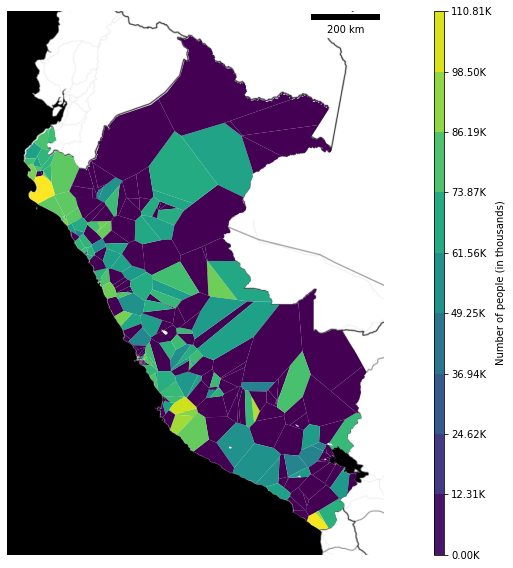

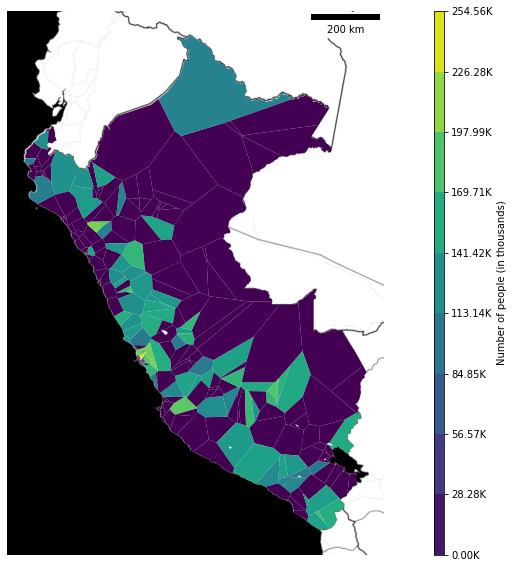

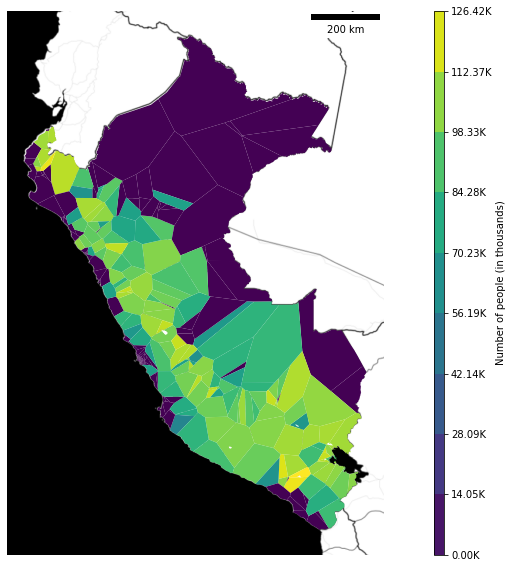

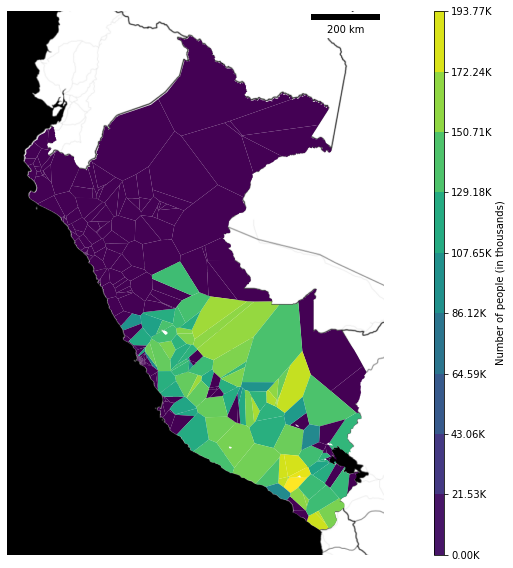

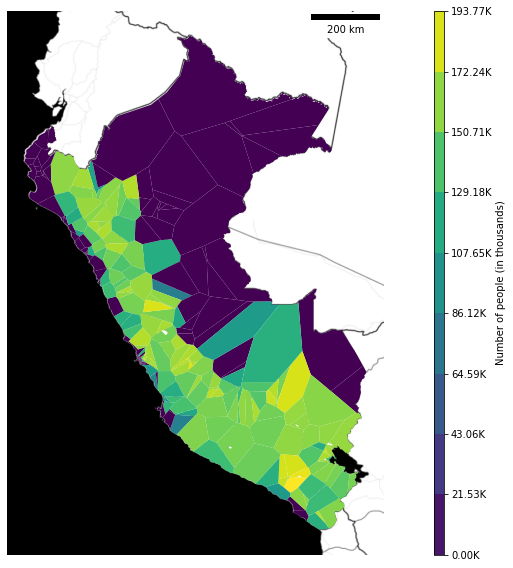

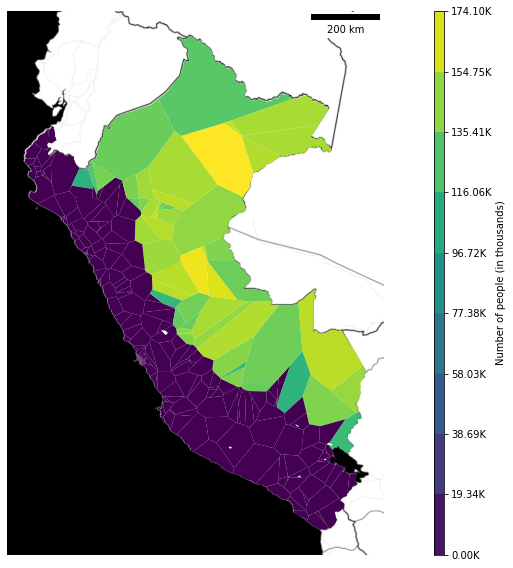

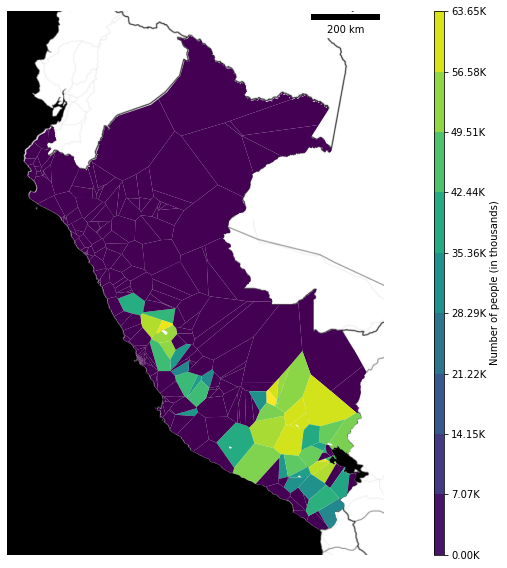

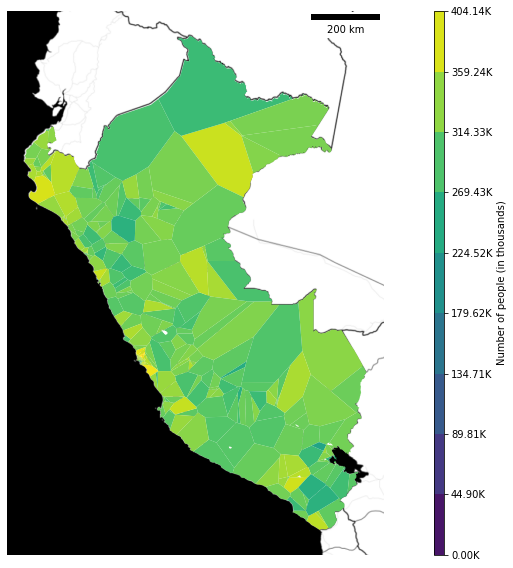

In [272]:
def get_color_scale(df, col_name):
    norm = mcolors.Normalize(
        vmin=min(df[col_name].dropna()), vmax=max(df[col_name].dropna())
    )
    return norm
    
for col_ in list_hazards+ ['total']:
    # data_temp = country_phc_voronoi.copy()
    data_temp = country_hospitals_voronoi.copy()
    col = col_
    col_g = col + "_g"
    data_temp[col_g] = data_temp[col].apply(lambda x: x ** (1/10))

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis("off")
    cmap_color = "viridis"
    norm = get_color_scale(data_temp, col_g)
    plot = data_temp.plot(
        ax=ax,
        column=col_g,
        cmap=cmap_color,
    )
    ctx.add_basemap(
        plot, crs="epsg:4326", source=ctx.providers.Stamen.TonerBackground, attribution=""
    )
    A = [-70.1 * np.pi / 180.0, -2.5 * np.pi / 180.0]
    B = [-70.8 * np.pi / 180.0, -2.5 * np.pi / 180.0]
    dx = (6371000) * haversine_distances([A, B])[0, 1]
    ax.add_artist(ScaleBar(dx=dx, units="m"))
    ticks = [
        max(data_temp[col].dropna()),
        ( max(data_temp[col].dropna()) - ((max(data_temp[col].dropna()) - min(data_temp[col].dropna())) / 2)),
        min(data_temp[col].dropna()),
    ]
    ticks = np.linspace(min(data_temp[col].dropna()),  max(data_temp[col].dropna()), 10)
    ticks_labels = [f"{x/1000:.2f}K" for x in ticks]  # Convert the values to thousands and format them as strings
    cax = fig.add_axes(
        [ax.get_position().x1 + 0.05, ax.get_position().y0, 0.01, ax.get_position().height]
    )

    cbar = fig.colorbar(
        cm.ScalarMappable(norm=norm, cmap=cmap_color),
        cax=cax,
        orientation="vertical",
        label="",
        boundaries=np.linspace(
            min(data_temp[col_g].dropna()), max(data_temp[col_g].dropna()), 10
        ),
    )
    cbar.ax.set_yticklabels(ticks_labels)
    cbar.set_label("Number of people (in thousands)")
    
    # path = f"{catchment_area}/peru_population_phc_voronoi_{col}_figure.png"
    path = f"{catchment_area}/peru_population_hospital_voronoi_{col}_figure.png"
    #country_hospitals_voronoi.to_csv(path, index = False)
    plt.savefig(path, format='png', dpi = 150, bbox_inches='tight')


## Voronoi antenas

In [51]:
def gdf_voronoi_antennae_function(data, area_shape):
    gdf = data.copy()
    gdf = gdf.to_crs(epsg=4326)
    print("Total de elementos:", len(gdf))
    gdf['hash'] = gdf['geometry'].apply(hash_point)
    gdf.drop_duplicates(subset='hash', keep='first', inplace=True)
    del gdf['hash']
    print("Eliminando puntos duplicados:", len(gdf))
    gdf = gdf[gdf.within(area_shape)].reset_index(drop=True)
    print("Eliminando areas fuera del poligono:", len(gdf))
    
    coords = points_to_coords(gdf.geometry)
    unique_coords, unique_indices = np.unique(coords, axis=0, return_index=True)
    region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)
    
    elements = []
    for i in range(0,len(region_polys)):
        pol = region_polys[i]
        lista = region_pts[i]
        for ind in lista:
            elements.append([ind, pol])

    elements = sorted(elements, key=lambda x: x[0])
    elements = complete_missing_elements(elements)
    elements = [e[1] for e in elements]

    gdf['geometry'] = elements
    gdf = gdf[~(gdf["geometry"].isna())].reset_index(drop=True)
    
    print("Poligonos procesados:", len(gdf))
    return gdf[['id','geometry']]

In [32]:
path = f"{PATH_DATA}/data/peru/preprocessed_sources/administrative_region"
files = os.listdir(path)

administrative_areas_dict = dict()
for i in files:
    name = fsupport.capitalize_string(i[:-8])
    administrative_areas_dict[name] = gpd.read_file(path + "/" + i)

administrative_areas = administrative_areas_dict[max(administrative_areas_dict.keys())]

filtered_columns = [
    col
    for col in administrative_areas.columns
    if col.endswith("code") or col == "geometry"
]
administrative_areas = administrative_areas[filtered_columns]
administrative_areas = administrative_areas.reindex(
    sorted(administrative_areas.columns), axis=1
)
administrative_areas = administrative_areas.to_crs("EPSG:4326")
administrative_areas.head()

administration_1_code administration_2_code administration_3_code   
0                    10                  1009                100902  \
1                    10                  1009                100904   
2                    25                  2503                250305   
3                    25                  2503                250302   
4                    25                  2503                250304   

                                            geometry  
0  POLYGON ((-75.31797 -9.29529, -75.31710 -9.297...  
1  POLYGON ((-75.20831 -9.10175, -75.20805 -9.101...  
2  POLYGON ((-74.95635 -8.79148, -74.95612 -8.792...  
3  POLYGON ((-75.10843 -8.79990, -75.11753 -8.812...  
4  POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...

In [63]:
from shapely.ops import cascaded_union, unary_union

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

from shapely.geometry import MultiPolygon, Polygon
from shapely.wkt import loads

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy.spatial import Voronoi, voronoi_plot_2d
import hashlib

catchment_area = f"{directory}/catchment_area2"
if not os.path.exists(catchment_area):
    os.makedirs(catchment_area)

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
shock_dict = {
    "floods": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/1_floods/Áreas_de_exposición.shp",
    "mass movements": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/2_mass movements/Áreas_de_exposición.shp",
    "droughts": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/4_Sequias/sequias_severas.shp",
    "landslide": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/3_huaycos/view_av_activ_qdra.shp",
    "frost": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/5_6_Heladas_friaje/Heladas.shp",
    "extreme cold": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/5_6_Heladas_friaje/Friajes.shp",
    "snow": f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/shocks_shapes/7_Snow/snow_peru.shp",
}
shock_dict

list_hazards = list(shock_dict.keys())
list_hazards

['floods',
 'mass movements',
 'droughts',
 'landslide',
 'frost',
 'extreme cold',
 'snow']

In [112]:
# Areas
area_shape = area_shape_function(administrative_areas)

# Antenas
gdf_path =  f"{PATH_DATA}/data/{COUNTRY_NAME}/original_sources/peru_extra/ANtenas ICT.xlsx"
df_antennae = pd.read_excel(gdf_path)
df_antennae = df_antennae.rename(columns={"IDUBIGEO": 'id', 'X_COORD (LONGITUD) ': 'lat', 'Y_COORD (LATITUD)': 'lon'})
df_antennae = df_antennae[['id', 'lat', 'lon']]
df_antennae = fsupport.hosp_join_points(df_antennae, administrative_areas)
df_antennae = df_antennae.dropna(subset=['geometry'])
df_antennae = df_antennae.dropna(subset=['id'])

# Others 
print("PROCESSING ANTENNAE")
country_antennae_voronoi = gdf_voronoi_antennae_function(df_antennae, area_shape)

country_antennae_voronoi = country_antennae_voronoi[['id', 'geometry', 'region']]
country_antennae_voronoi['centroid'] = country_antennae_voronoi['geometry'].centroid
country_antennae_voronoi.head()

id                                           geometry   
0  101010001.0  POLYGON ((-77.88154 -6.23410, -77.87109 -6.235...  \
1  101010002.0  POLYGON ((-77.88733 -6.20701, -77.88699 -6.193...   
2  101010003.0  POLYGON ((-77.86452 -6.21008, -77.86046 -6.194...   
3  101010004.0  POLYGON ((-77.84284 -6.22497, -77.83182 -6.199...   
4  101010005.0  POLYGON ((-77.81094 -6.22674, -77.84284 -6.224...   

                                              region   
0  POLYGON ((-77.88154 -6.23410, -77.87109 -6.235...  \
1  POLYGON ((-77.88733 -6.20701, -77.88699 -6.193...   
2  POLYGON ((-77.86452 -6.21008, -77.86046 -6.194...   
3  POLYGON ((-77.84284 -6.22497, -77.83182 -6.199...   
4  POLYGON ((-77.81094 -6.22674, -77.84284 -6.224...   

                     centroid  
0  POINT (-77.86854 -6.22798)  
1  POINT (-77.89903 -6.19834)  
2  POINT (-77.87453 -6.20104)  
3  POINT (-77.84813 -6.20577)  
4  POINT (-77.82499 -6.21630)

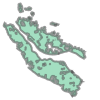

In [114]:
SHOCK_NAME = 'landslide'

path_shock_file = shock_dict[SHOCK_NAME]
shock_shape = fsupport.shock_shape(path=path_shock_file, shock_name=SHOCK_NAME)
shock_shape = shock_shape.unary_union

shock_shape

<Axes: >

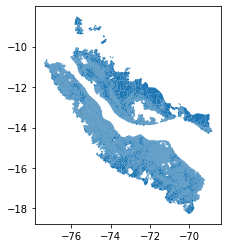

In [115]:
country_antennae_voronoi_sub = country_antennae_voronoi[country_antennae_voronoi.centroid.within(shock_shape)]
country_antennae_voronoi_sub.plot()


In [117]:
path = PATH_DATA + "/data/peru/preprocessed_sources/population.geojson"
population_shock_df = gpd.read_file(path)
population_shock_df = fsupport.extract_centroid_if_exist(population_shock_df)
population_shock_df = population_shock_df[['population','geometry']]
population_shock_df = population_shock_df.rename(columns={"population": 'Population'})
population_shock_df['population_id'] = population_shock_df.index
print('     Population:',sum(population_shock_df['Population']))

     Population: 21744633


In [121]:
population_shock_df_in = gpd.sjoin(population_shock_df, country_antennae_voronoi_sub, op="within")
print(sum(population_shock_df_in['Population']))
population_shock_df_in.head()

2095730


Population                     geometry  population_id  index_right   
10405          40  POINT (-72.88612 -13.62524)          10405        11167  \
10406          60  POINT (-72.88651 -13.62528)          10406        11167   
10407          36  POINT (-72.88651 -13.62570)          10407        11167   
10408          75  POINT (-72.88614 -13.62566)          10408        11167   
10409          65  POINT (-72.88636 -13.62610)          10409        11167   

                id                                             region   
10405  301010020.0  POLYGON ((-72.88743 -13.61998, -72.88439 -13.6...  \
10406  301010020.0  POLYGON ((-72.88743 -13.61998, -72.88439 -13.6...   
10407  301010020.0  POLYGON ((-72.88743 -13.61998, -72.88439 -13.6...   
10408  301010020.0  POLYGON ((-72.88743 -13.61998, -72.88439 -13.6...   
10409  301010020.0  POLYGON ((-72.88743 -13.61998, -72.88439 -13.6...   

                          centroid  
10405  POINT (-72.88812 -13.62626)  
10406  POINT (-72.88812 -13.62626)  
10407  POINT (-72.88812 -13.62626)  
10408  POINT (-72.88812 -13.62626)  
10409  POINT (-72.88812 -13.62626)

In [123]:
#population_shock_df_in = gpd.sjoin(population_shock_df, country_antennae_voronoi, op="within")
population_shock_df_in = voronoi_antennae_join_nearest_points(population_shock_df, country_antennae_voronoi)
print(sum(population_shock_df_in['Population']))
population_shock_df_in.head()

21744633


Population                    geometry  population_id         id   
0          34  POINT (-77.87966 -6.22034)              0  101010007  \
1          70  POINT (-77.87829 -6.22222)              1  101010007   
2          62  POINT (-77.87836 -6.22265)              2  101010007   
3          42  POINT (-77.87810 -6.22352)              3  101010007   
4          70  POINT (-77.87759 -6.22441)              4  101010007   

                                              region   
0  POLYGON ((-77.89671 -6.22755, -77.89315 -6.212...  \
1  POLYGON ((-77.89671 -6.22755, -77.89315 -6.212...   
2  POLYGON ((-77.89671 -6.22755, -77.89315 -6.212...   
3  POLYGON ((-77.89671 -6.22755, -77.89315 -6.212...   
4  POLYGON ((-77.89671 -6.22755, -77.89315 -6.212...   

                     centroid  
0  POINT (-77.88679 -6.22104)  
1  POINT (-77.88679 -6.22104)  
2  POINT (-77.88679 -6.22104)  
3  POINT (-77.88679 -6.22104)  
4  POINT (-77.88679 -6.22104)

In [ ]:

for SHOCK_NAME_RAW in list_hazards + ['total']:
    print("  ",SHOCK_NAME_RAW)
    if 'total' == SHOCK_NAME_RAW:
        pass
    else:
        country_antennae_voronoi_sub = country_antennae_voronoi[country_antennae_voronoi.centroid.within(shock_shape)]
        country_antennae_voronoi_sub.plot()
        

In [86]:


# Population for each region
for SHOCK_NAME_RAW in list_hazards + ['total']:
    print("  ",SHOCK_NAME_RAW)
    if 'total' == SHOCK_NAME_RAW:
        # population_shock_df = gpd.GeoDataFrame(population_shock_df, crs="EPSG:4326")
        path = PATH_DATA + "/data/peru/preprocessed_sources/population.geojson"
        population_shock_df = gpd.read_file(path)
        population_shock_df = fsupport.extract_centroid_if_exist(population_shock_df)
        population_shock_df = population_shock_df[['population','geometry']]
        population_shock_df = population_shock_df.rename(columns={"population": 'Population'})
        print('     Population:',sum(population_shock_df['Population']))
        population_shock_df['population_id'] = population_shock_df.index
        data_temp = voronoi_antennae_join_nearest_points(population_shock_df, country_antennae_voronoi)
        data_temp = data_temp.groupby(['id']).agg(
                                                Population=("Population", "sum")
                                            ).reset_index()
        data_temp = data_temp.rename(columns={"Population": SHOCK_NAME_RAW})
        country_antennae_voronoi = pd.merge(
                                country_antennae_voronoi,
                                data_temp,
                                how="left", 
                                left_on=['id'], 
                                right_on=['id']
                            )
        country_antennae_voronoi[SHOCK_NAME_RAW] = country_antennae_voronoi[SHOCK_NAME_RAW].fillna(0)
        country_antennae_voronoi[SHOCK_NAME_RAW] = country_antennae_voronoi[SHOCK_NAME_RAW].astype(int)
    else:
        path = f"{directory}/{SHOCK_NAME_RAW}/peru_population_points_{SHOCK_NAME_RAW}_table.csv"
        population_shock_df = pd.read_csv(path)
        population_shock_df = population_shock_df[population_shock_df['Shock Name']==1]
        population_shock_df = population_shock_df.iloc[:,1:]
        population_shock_df['geometry'] = population_shock_df['geometry'].apply(lambda x: loads(x))
        population_shock_df = gpd.GeoDataFrame(population_shock_df, crs="EPSG:4326")
        print('     Population:',sum(population_shock_df['Population']))
        population_shock_df['population_id'] = population_shock_df.index
        data_temp = voronoi_antennae_join_nearest_points(population_shock_df, country_antennae_voronoi)
        data_temp = data_temp.groupby(['id']).agg(
                                                Population=("Population", "sum")
                                            ).reset_index()
        data_temp = data_temp.rename(columns={"Population": SHOCK_NAME_RAW})
        country_antennae_voronoi = pd.merge(
                                country_antennae_voronoi,
                                data_temp,
                                how="left", 
                                left_on=['id'], 
                                right_on=['id']
                            )
        country_antennae_voronoi[SHOCK_NAME_RAW] = country_antennae_voronoi[SHOCK_NAME_RAW].fillna(0)
        country_antennae_voronoi[SHOCK_NAME_RAW] = country_antennae_voronoi[SHOCK_NAME_RAW].astype(float)
    
# Save file
path = f"{catchment_area}/peru_population_antennae_voronoi_table.csv"
country_antennae_voronoi.to_csv(path, index = False)


   floods
     Population: 1017836
   mass movements
     Population: 1201262
   droughts
     Population: 2633686
   landslide
     Population: 2168505
   frost
     Population: 5394732
   extreme cold
     Population: 1942297
   snow
     Population: 562403
   total
     Population: 21744633


In [82]:
sum(population_shock_df['Population'])

21744633

In [87]:
for SHOCK_NAME_RAW in list_hazards + ['total']:
    sum_raw = int(sum(country_antennae_voronoi[SHOCK_NAME_RAW]))
    print(SHOCK_NAME_RAW, ':', sum_raw)

floods : 1017836
mass movements : 1201262
droughts : 2633686
landslide : 2168505
frost : 5394732
extreme cold : 1942297
snow : 562403
total : 21744633


In [77]:
print(country_antennae_voronoi['landslide'].sum())
print(country_antennae_voronoi['total'].sum())

2168505.0
21744633


In [78]:
sum(country_antennae_voronoi['landslide'])

2168505.0

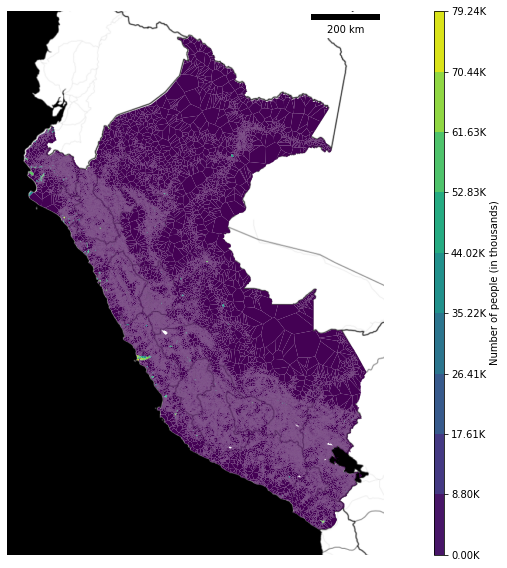

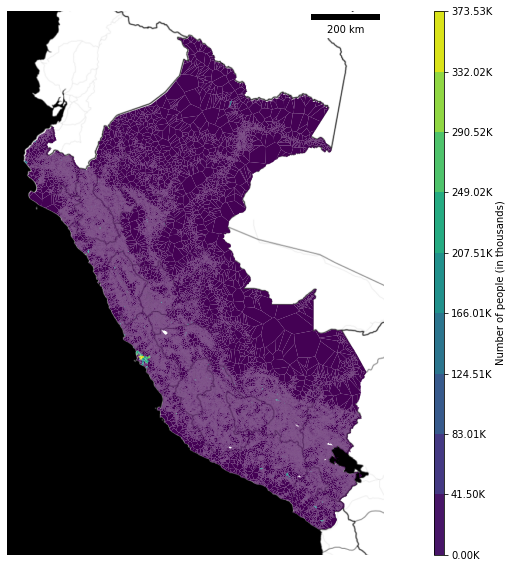

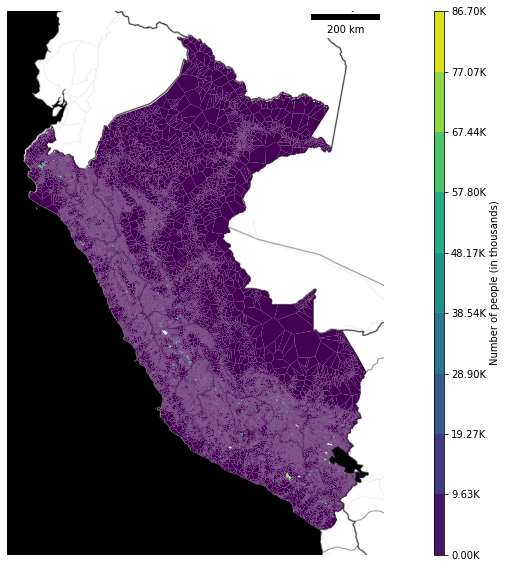

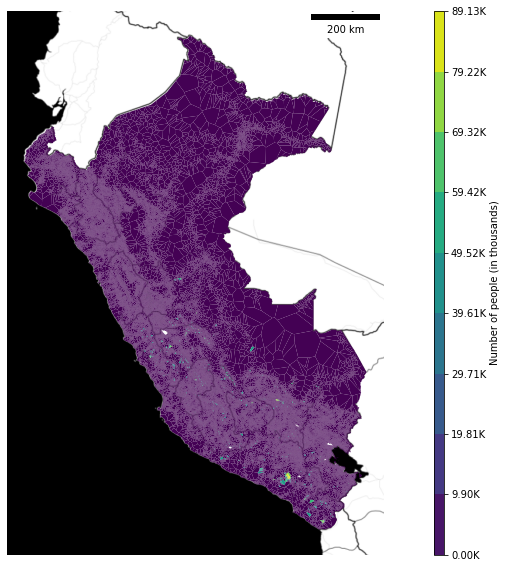

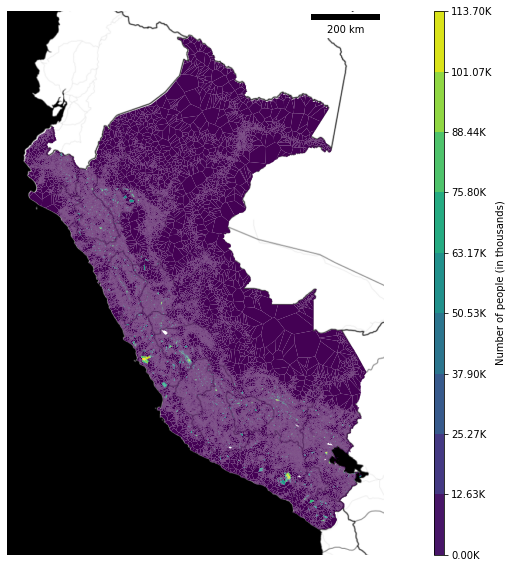

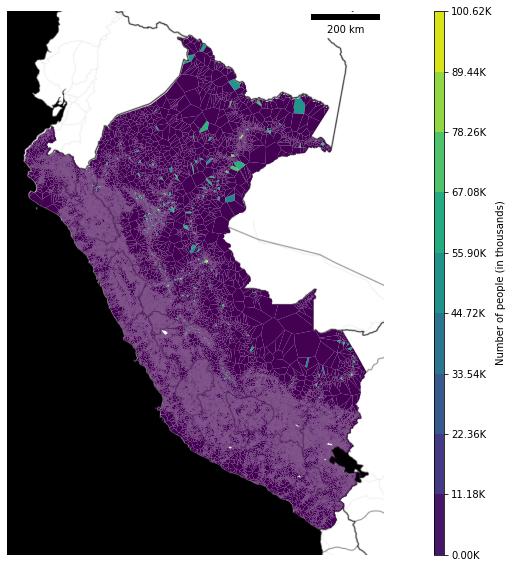

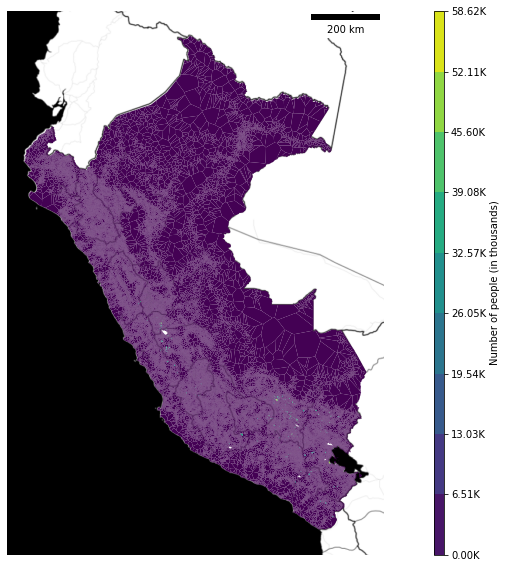

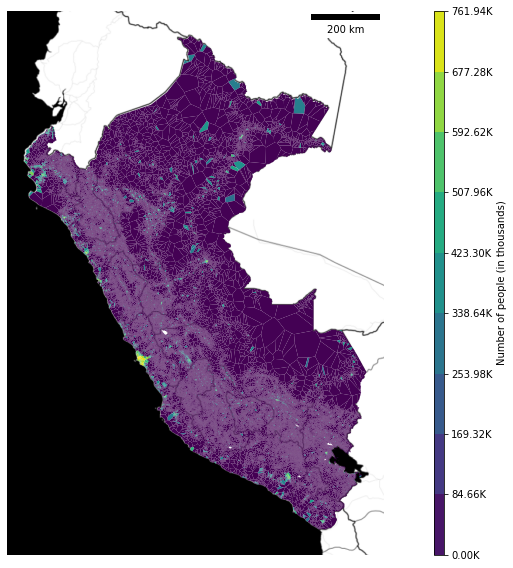

In [74]:
def get_color_scale(df, col_name):
    norm = mcolors.Normalize(
        vmin=min(df[col_name].dropna()), vmax=max(df[col_name].dropna())
    )
    return norm
    
for col_ in list_hazards+ ['total']:
    data_temp = country_antennae_voronoi.copy()
    col = col_
    col_g = col + "_g"
    data_temp[col_g] = data_temp[col].apply(lambda x: x ** (1/10))

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis("off")
    cmap_color = "viridis"
    norm = get_color_scale(data_temp, col_g)
    plot = data_temp.plot(
        ax=ax,
        column=col_g,
        cmap=cmap_color,
    )
    ctx.add_basemap(
        plot, crs="epsg:4326", source=ctx.providers.Stamen.TonerBackground, attribution=""
    )
    A = [-70.1 * np.pi / 180.0, -2.5 * np.pi / 180.0]
    B = [-70.8 * np.pi / 180.0, -2.5 * np.pi / 180.0]
    dx = (6371000) * haversine_distances([A, B])[0, 1]
    ax.add_artist(ScaleBar(dx=dx, units="m"))
    ticks = [
        max(data_temp[col].dropna()),
        ( max(data_temp[col].dropna()) - ((max(data_temp[col].dropna()) - min(data_temp[col].dropna())) / 2)),
        min(data_temp[col].dropna()),
    ]
    ticks = np.linspace(min(data_temp[col].dropna()),  max(data_temp[col].dropna()), 10)
    ticks_labels = [f"{x/1000:.2f}K" for x in ticks]  # Convert the values to thousands and format them as strings
    cax = fig.add_axes(
        [ax.get_position().x1 + 0.05, ax.get_position().y0, 0.01, ax.get_position().height]
    )

    cbar = fig.colorbar(
        cm.ScalarMappable(norm=norm, cmap=cmap_color),
        cax=cax,
        orientation="vertical",
        label="",
        boundaries=np.linspace(
            min(data_temp[col_g].dropna()), max(data_temp[col_g].dropna()), 10
        ),
    )
    cbar.ax.set_yticklabels(ticks_labels)
    cbar.set_label("Number of people (in thousands)")
    
    path = f"{catchment_area}/peru_population_antennae_voronoi_{col}_figure.png"
    plt.savefig(path, format='png', dpi = 150, bbox_inches='tight')


In [65]:
catchment_area

'/Users/johnbarrera/Documents/My_projects/Analysis/IA_risk_index/data/peru/results_INEI/catchment_area2'